In [12]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML, display

import sweep 
from sweep.sweep_load import pload1d, load_meta
from cappy.config import DATA2_PATH

In [2]:
FEB6SWEEP_ID = 17
NUMSWEEPS = 15

# Feb 7th

In [3]:
data_id = FEB6SWEEP_ID + 0 
bode_data = pload1d(DATA2_PATH, data_id)
bode_data["lockin_P"]

array([   3.79306006,  -37.7263298 , -140.22639465, -142.81332397,
       -145.42378235, -148.72035217, -151.53303528, -154.18511963,
       -155.80804443, -157.07460022, -158.11531067, -159.0302124 ,
       -159.99943542, -160.9336853 , -161.76644897, -162.19937134,
       -162.80413818, -163.27772522, -163.92738342, -164.23774719,
       -164.60015869, -165.08488464, -165.29222107, -165.78973389,
       -166.3404541 , -166.44064331, -166.68305969, -167.09255981,
       -167.35688782, -167.65795898, -167.85316467, -168.25337219,
       -168.31692505, -168.48223877, -168.7260437 , -169.0042572 ,
       -169.16398621, -169.28631592, -169.50587463, -169.6542511 ,
       -169.81359863, -169.95916748, -170.10935974, -170.25254822,
       -170.45811462, -170.57182312, -170.68919373, -170.79563904,
       -170.9198761 , -171.01081848, -171.13305664, -171.29046631,
       -171.331604  , -171.47134399, -171.58807373, -171.69985962,
       -171.88127136, -171.89616394, -172.02702332, -172.10772

In [4]:
flat_ids = []
for i in range(NUMSWEEPS):
    data_id = FEB6SWEEP_ID + i 
    bode_data = pload1d(DATA2_PATH, data_id)

    # Extract vres_setpoint for each sweep
    comments = load_meta(DATA2_PATH, data_id)['comments']
    vgres_pt = float(comments[0].split("= ")[-1])
    
    # ignore first 2 points (not stable)
    ignore_idx = 2
    # make plots
    freqs = bode_data['acdac_frequency'][1::]
    mags = bode_data['lockin_R'][1::]
    phases = bode_data['lockin_P'][1::]
    phases = np.where(phases < 0, phases + 360, phases)

    flat_ids.append(np.std(mags))

    fig, ax = plt.subplots(2,1,sharex=True)
    ax[1].set_xscale("log")
    ax[1].set_xlabel(rf'Frequency (Hz)')
    
    ax[0].plot(freqs, mags)
    ax[0].set_ylabel('Magnitude (V)')

    ax[1].plot(freqs, phases)
    ax[1].set_ylabel('Phase (deg)')

    # Set title for the entire figure
    fig.suptitle(rf"Transfer function for $V_{{Gres}}$ = {vgres_pt:.3f}V")

    plt.show()

In [5]:
# Load all data first to avoid reloading in every frame
bode_data_list = []
vgres_pts = []

# ignore first few points (not stable
ignore_idx = 2
for i in range(NUMSWEEPS):
    data_id = FEB6SWEEP_ID + i 
    bode_data = pload1d(DATA2_PATH, data_id)

    comments = load_meta(DATA2_PATH, data_id)['comments']
    vgres_pt = float(comments[0].split("= ")[-1])
    
    phases = bode_data['lockin_P'][ignore_idx::]
    phases = np.where(phases < 0, phases + 360, phases)

    # Store data
    bode_data_list.append({
        "freqs": bode_data['acdac_frequency'][ignore_idx::],
        "mags": bode_data['lockin_R'][ignore_idx::],
        "phases": phases,
    })
    vgres_pts.append(vgres_pt)

In [6]:
# Create figure and axes
fig, ax = plt.subplots(2, 1, sharex=True)

fig.subplots_adjust(top=0.90) #djust top margin to fit title better

ax[1].set_xscale("log")
ax[1].set_xlabel('Frequency (Hz)')

ax[0].set_ylabel('Magnitude (V)')
ax[1].set_ylabel('Phase (deg)')

# Initial empty plots
mag_line, = ax[0].plot([], [], label="Magnitude")
phase_line, = ax[1].plot([], [], label="Phase")

# Title for animation
title = fig.suptitle("Transfer Functions as $V_{{Gres}}$ is varied")

def update(frame):
    """Updates the plot for each frame in the animation."""
    data = bode_data_list[frame]
    
    mag_line.set_data(data["freqs"], data["mags"])
    phase_line.set_data(data["freqs"], data["phases"])
    
    ax[0].relim()
    ax[0].autoscale_view()
    ax[1].relim()
    ax[1].autoscale_view()
    
    title.set_text(rf"$V_{{Gres}}$ = {vgres_pts[frame]:.3f}V")

    return mag_line, phase_line, title

# Create animation
ani = animation.FuncAnimation(fig, update, frames=NUMSWEEPS, interval=1000, blit=False)
ani.save(filename="vgres_sweep.gif", writer="pillow")
plt.show()

# Mar 26

In [13]:
MAR26SWEEP_ID = 60
NUMSWEEPS = 15

In [ ]:
# Load all data first to avoid reloading in every frame
bode_data_list = []
vgres_pts = []

# ignore first few points (not stable
ignore_idx = 1
for i in range(NUMSWEEPS):
    data_id = MAR26SWEEP_ID + i 
    bode_data = pload1d(DATA2_PATH, data_id)

    comments = load_meta(DATA2_PATH, data_id)['comments']
    vgres_pt = float(comments[0].split("= ")[-1])
    
    phases = bode_data['lockin_P'][ignore_idx::]
    phases = np.where(phases < 0, phases + 360, phases)

    # Store data
    bode_data_list.append({
        "freqs": bode_data['acdac_frequency'][ignore_idx::],
        "mags": bode_data['lockin_R'][ignore_idx::],
        "phases": phases,
    })
    vgres_pts.append(vgres_pt)

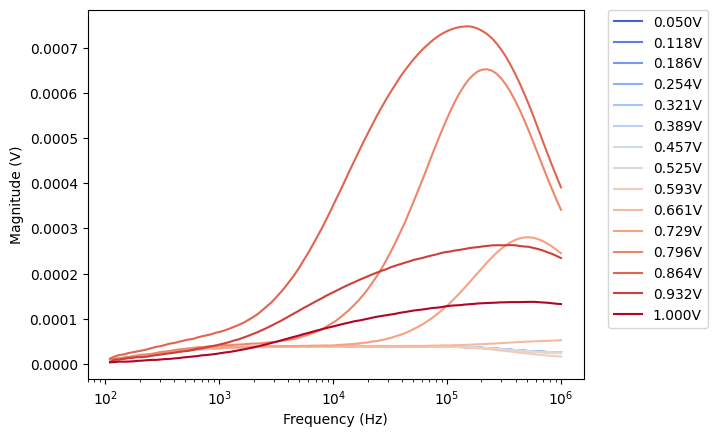

In [24]:
for i in range(NUMSWEEPS):
    fs = bode_data_list[i]["freqs"]
    mags = bode_data_list[i]["mags"]
    c = plt.cm.coolwarm(vgres_pts[i]/max(vgres_pts))
    plt.plot(fs, mags, label=f"{vgres_pts[i]:.3f}V", color=c)
    
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (V)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

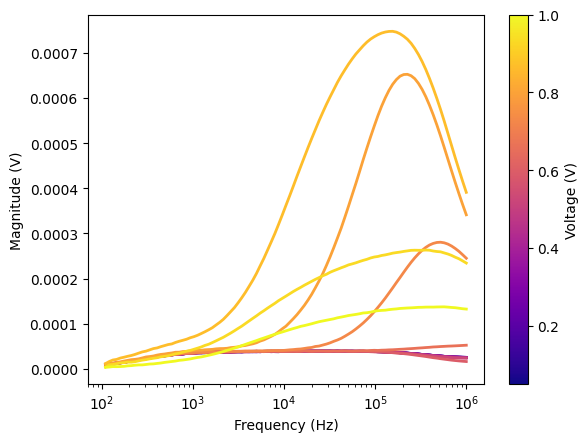

In [29]:
# Use a colormap with distinct colors
cmap = plt.cm.plasma  # A more distinct and clear colormap
norm = plt.Normalize(vmin=min(vgres_pts), vmax=max(vgres_pts))  # Normalize the voltage values

# Create a scatter plot for color mapping
scalars = plt.scatter([], [], c=[], cmap=cmap, norm=norm)
# We just create an empty scatter plot to use for the colorbar
# Pass c=[] to avoid showing any points, as we only need the colorbar

# Plot each sweep with clearer colors
for i in range(NUMSWEEPS):
    fs = bode_data_list[i]["freqs"]
    mags = bode_data_list[i]["mags"]
    color = cmap(norm(vgres_pts[i]))  # Get a distinct color based on voltage value
    plt.plot(fs, mags, label=f"{vgres_pts[i]:.3f}V", color=color, linewidth=2)

# Add a colorbar using the scatter plot for color mapping
plt.colorbar(scalars, label="Voltage (V)")

# Improve the plot appearance
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (V)")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [5]:
# Create figure and axes
fig, ax = plt.subplots(2, 1, sharex=True)

fig.subplots_adjust(top=0.90) #djust top margin to fit title better

ax[1].set_xscale("log")
ax[1].set_xlabel('Frequency (Hz)')

ax[0].set_ylabel('Magnitude (V)')
ax[1].set_ylabel('Phase (deg)')

# Initial empty plots
mag_line, = ax[0].plot([], [], label="Magnitude")
phase_line, = ax[1].plot([], [], label="Phase")

# Title for animation
title = fig.suptitle("Transfer Functions as $V_{{Gres}}$ is varied")

def update(frame):
    """Updates the plot for each frame in the animation."""
    data = bode_data_list[frame]
    
    mag_line.set_data(data["freqs"], data["mags"])
    phase_line.set_data(data["freqs"], data["phases"])
    
    ax[0].relim()
    ax[0].autoscale_view()
    ax[1].relim()
    ax[1].autoscale_view()
    
    title.set_text(rf"$V_{{Gres}}$ = {vgres_pts[frame]:.3f}V")

    return mag_line, phase_line, title

# Create animation
ani = animation.FuncAnimation(fig, update, frames=NUMSWEEPS, interval=1000, blit=False)
# ani.save(filename="vgres_sweep.gif", writer="pillow")
plt.show()